### Generating human faces with Adversarial Networks
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc.

Based on https://github.com/Lasagne/Recipes/pull/94 .

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]
IMG_SHAPE

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


(36, 36, 3)

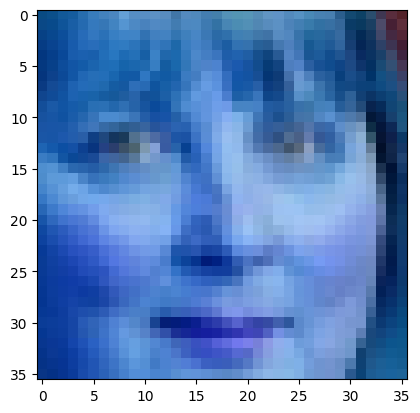

In [2]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it?
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent


The only problem is: how can we tell well-generated faces from bad?

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample.
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake.
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [3]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L

In [4]:
CODE_SIZE = 100
generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))
generator.add(L.Reshape((8,8,10)))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2D(3, kernel_size=(3,3)))



In [5]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
Discriminator is your usual convolutional network with interlooping convolution and pooling layers

In [6]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))
discriminator.add(L.Conv2D(64, kernel_size = (1, 1), kernel_initializer='glorot_uniform', use_bias = True))
discriminator.add(L.LeakyReLU())
discriminator.add(L.Dropout(0.3))

discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh', use_bias = True))
discriminator.add(L.Dense(2))
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 36, 36, 64)        256       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 36, 36, 64)        0         
                                                                 
 dropout (Dropout)           (None, 36, 36, 64)        0         
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense_1 (Dense)             (None, 256)               21233920  
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21,234,690
Trainable params: 21,234,690


# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real

![img](gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* You can find useful tricks here https://github.com/soumith/ganhacks

### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [7]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    print()
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [11]:
disc_optimizer = tf.keras.optimizers.Adam(1e-4)
gen_optimizer = tf.keras.optimizers.Adam(1e-4)

1/1 [==============================] - 0s 21ms/step


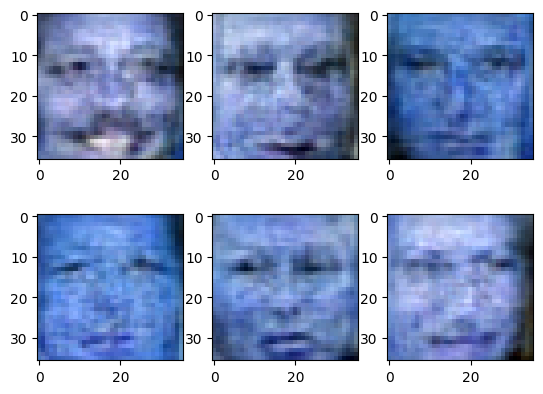

4/4 [==============================] - 0s 3ms/step

4/4 [==============================] - 0s 2ms/step


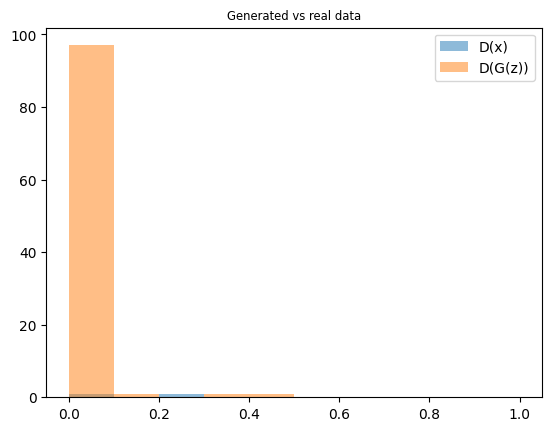

tf.Tensor(0.06126908, shape=(), dtype=float32)
19900
tf.Tensor(6.9266386, shape=(), dtype=float32)


In [12]:
from IPython import display
from tqdm.notebook import tnrange

for epoch in tnrange(20000):
    real_data = sample_data_batch(100)
    noise = sample_noise_batch(100)
    for i in range(5):

        with tf.GradientTape(persistent=True) as disc_tape:
            logp_real = discriminator(real_data)

            generated_data = generator(noise)

            logp_gen = discriminator(generated_data)
            disc_loss = discriminator_loss(logp_real,logp_gen)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    #optimize
    with tf.GradientTape(persistent=True) as gen_tape:
        generated_data = generator(noise)
        im = discriminator(generated_data)
        g_loss = generator_loss(im)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    if epoch %100==0:
        display.clear_output(wait=True)
        sample_images(2,3,False)
        sample_probas(100)
        print(disc_loss)
        print(epoch)
        print(g_loss)


In [37]:
generator.save('adv.h5')